## *RISK*-like mechanics

[Wikipedia.](<https://en.wikipedia.org/wiki/Risk_(game)>)

This mechanic operates as follows:

* Two sides each roll a pool of dice (usually d6s).
* Pairs of dice are taken, one from each side, starting from the highest dice.
* Unpaired dice are ignored.

Each side scores one point for each pair on which they have the higher number.
Depending on the mechanic:

* Matching pairs may go to one side, or count as nothing.
* Both sides' points may matter, or only the difference.

In [1]:
%pip install icepool

import icepool
from icepool import d6

class EvalRisk(icepool.MultisetEvaluator):
    def next_state(self, state, outcome, a, b):
        if state is None:
            score_a, score_b, advantage = 0, 0, 0
        else:
            score_a, score_b, advantage = state
        # Advantage is the number of unpaired dice that rolled a previous (higher) number.
        # If positive, it favors side A, otherwise it favors side B.
        # We pair them off with newly-rolled dice of the disadvantaged side.
        if advantage > 0:
            score_a += min(b, advantage)
        elif advantage < 0:
            score_b += min(a, -advantage)
        advantage += a - b
        return score_a, score_b, advantage
    
    def final_outcome(self, final_state):
        # Take only the scores.
        return final_state[:2]
    
    def order(self, *_):
        # See outcomes in descending order.
        return -1

eval_risk = EvalRisk()

# In the board game, defenders win ties.
# I.e. whatever the attack doesn't win, the defender wins.
# So we just take the attacker score.

# 3 vs. 2 dice.
print(eval_risk(d6.pool(3), d6.pool(2)).marginals[0])

Denominator: 7776

| Outcome | Weight | Chance (%) |
|--------:|-------:|-----------:|
|       0 |   2275 |  29.256687 |
|       1 |   2611 |  33.577675 |
|       2 |   2890 |  37.165638 |



In [2]:
# If instead, ties meant nothing, here's the score of each side:
print(eval_risk(d6.pool(3), d6.pool(2)))

Denominator: 7776

| Outcome[0] | Outcome[1] | Weight | Chance (%) |
|-----------:|-----------:|-------:|-----------:|
|          0 |          0 |    381 |   4.899691 |
|          0 |          1 |    915 |  11.766975 |
|          0 |          2 |    979 |  12.590021 |
|          1 |          0 |   1545 |  19.868827 |
|          1 |          1 |   1066 |  13.708848 |
|          2 |          0 |   2890 |  37.165638 |



In [3]:
# If we are only interested in the difference, we could take the difference after the fact.
# But it's more efficient to do it during the evaluation of the pool.

class EvalRiskDiff(icepool.MultisetEvaluator):
    def next_state(self, state, outcome, a, b):
        if state is None:
            net_score, advantage = 0, 0
        else:
            net_score, advantage = state
        # Advantage is the number of unpaired dice that rolled a previous (higher) number.
        # If positive, it favors side A, otherwise it favors side B.
        # We pair them off with newly-rolled dice of the disadvantaged side.
        if advantage > 0:
            net_score += min(b, advantage)
        elif advantage < 0:
            net_score -= min(a, -advantage)
        advantage += a - b
        return net_score, advantage
    
    def final_outcome(self, final_state):
        # Take only the score.
        return final_state[0]
    
    def order(self, *_):
        # See outcomes in descending order.
        return -1

eval_risk_diff = EvalRiskDiff()
    
# 3 vs. 3 dice.
print(eval_risk_diff(d6.pool(3), d6.pool(3)))

Denominator: 46656

| Outcome | Weight | Chance (%) |
|:--------|-------:|-----------:|
| -3      |   6420 |  13.760288 |
| -2      |   6810 |  14.596193 |
| -1      |   6852 |  14.686214 |
| 0       |   6492 |  13.914609 |
| 1       |   6852 |  14.686214 |
| 2       |   6810 |  14.596193 |
| 3       |   6420 |  13.760288 |



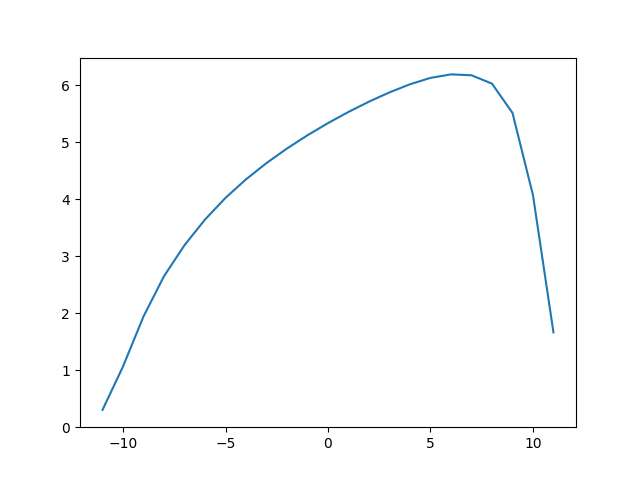

In [4]:
# How about more dice?

# 12 vs. 11 dice.
result = eval_risk_diff(d6.pool(12), d6.pool(11))

# Plot using matplotlib.

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(result.outcomes(), result.probabilities(percent=True))
ax.set_ylim(bottom=0)
plt.show()